In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

Question 3: What attributes of a movie (e.g., runtime, genre, budget) tend have the greatest impact on the IMDb rating according to this sample?

In [3]:
# Load CSV
df = pd.read_csv("juroe_project_proposal.csv", encoding = "UTF-8")
display(df)

,Rank,Movie Title,Wins,Nominations,year,rating,genre,score,votes,country,budget,gross,company,runtime
0,1,The Shawshank Redemption,21,42,1994,R,Drama,9.3,2400000.0,United States,25000000.0,2.881729e+07,Castle Rock Entertainment,142.0
1,3,The Dark Knight,164,165,2008,PG-13,Action,9.0,2400000.0,United States,185000000.0,1.005974e+09,Warner Bros.,152.0
2,6,The Lord of the Rings: The Return of the King,215,124,2003,PG-13,Action,8.9,1700000.0,New Zealand,94000000.0,1.146031e+09,New Line Cinema,201.0
3,7,Schindler's List,91,49,1993,R,Biography,8.9,1200000.0,United States,22000000.0,3.221612e+08,Universal Pictures,195.0
4,8,Pulp Fiction,69,72,1994,R,Crime,8.9,1900000.0,United States,8000000.0,2.139288e+08,Miramax,154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,244,Into the Wild,13,6,2007,R,Adventure,8.1,588000.0,United States,15000000.0,5.667590e+07,Paramount Vantage,148.0
138,246,Groundhog Day,7,17,1993,PG,Comedy,8.0,589000.0,United States,14600000.0,7.107405e+07,Columbia Pictures,101.0
139,247,The Help,79,121,2011,PG-13,Drama,8.0,436000.0,United States,25000000.0,2.166391e+08,DreamWorks,146.0
140,248,Amores Perros,55,24,2000,R,Drama,8.1,228000.0,Mexico,2000000.0,2.090847e+07,Altavista Films,154.0


In [4]:
# Pearson Correlation: Runtime and Budget vs IMDb Rating
runtime_corr, runtime_p = pearsonr(df['runtime'], df['score'])
budget_corr, budget_p = pearsonr(df['budget'], df['score'])
print(f"Pearson Correlation - Runtime vs Score: r={runtime_corr:.4f}, p={runtime_p:.4f}")
print(f"Pearson Correlation - Budget vs Score: r={budget_corr:.4f}, p={budget_p:.4f}")

Pearson Correlation - Runtime vs Score: r=0.3680, p=0.0000
Pearson Correlation - Budget vs Score: r=0.1115, p=0.1863


In [5]:
# ANOVA Test: Genre Impact on IMDb Rating
genres = df['genre'].unique()
genre_groups = [df[df['genre'] == genre]['score'] for genre in genres if len(df[df['genre'] == genre]) > 1]
stat, p = f_oneway(*genre_groups)
print(f"ANOVA Test on Genres: stat={stat:.4f}, p={p:.4f}")

ANOVA Test on Genres: stat=0.6406, p=0.7216


In [6]:
# ANOVA Test: Genre Impact on IMDb Rating using statsmodels
fit = ols("score ~ genre", data=df).fit()
anova_table = sm.stats.anova_lm(fit, typ=2)
print(anova_table)

# Extract and interpret the p-value
p_value = anova_table["PR(>F)"].iloc[0]
print(f"P-value: {p_value:.8f}")

alpha = 0.05
if p_value < alpha:
    print("Reject H0: The average IMDb ratings are significantly different across genres.")
else:
    print("Fail to reject H0: No significant difference in average IMDb ratings across genres.")

            sum_sq     df        F   PR(>F)
genre     0.306235    8.0  0.66235  0.72376
Residual  7.686511  133.0      NaN      NaN
P-value: 0.72375956
Fail to reject H0: No significant difference in average IMDb ratings across genres.


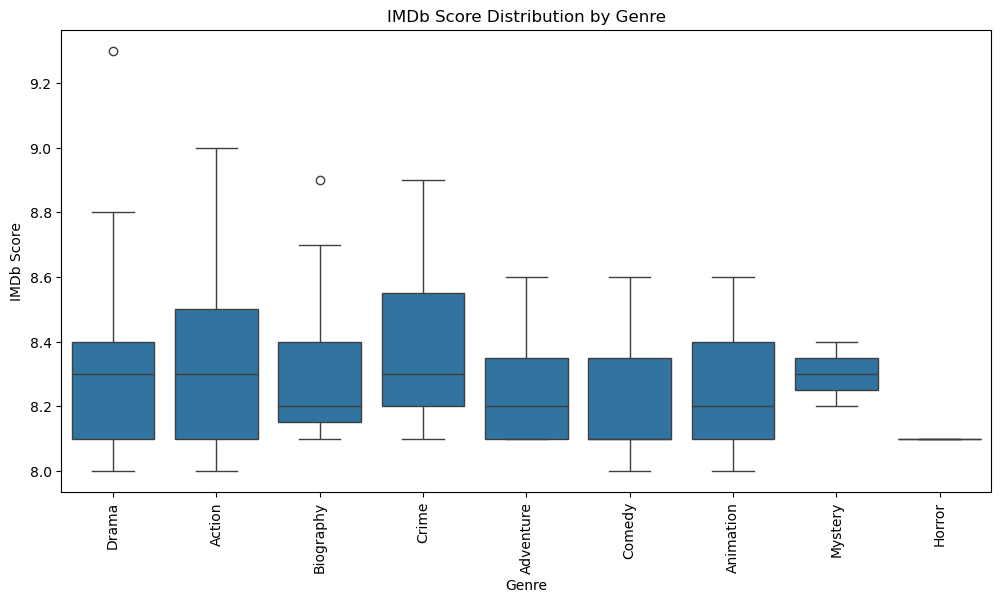

In [7]:
# Visualization: IMDb Rating by Genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='score', data=df)
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("IMDb Score")
plt.title('IMDb Score Distribution by Genre')
plt.show()

### Machine Learning: Logistic Regression

In [9]:
# Create a binary target: 1 if score >= mean of scores, else 0
mean_score = df['score'].mean()
df['high_score'] = (df['score'] >= mean_score).astype(int)
print(f"Mean IMDb score: {mean_score:.2f}")

Mean IMDb score: 8.32


In [10]:
# Make dummy variables for 'rating' and the train/test split for the logistic regression
df = pd.get_dummies(df, columns=['rating'], drop_first=True)
    
X = df.drop(columns=['Rank', 'Movie Title', 'Wins', 'Nominations', 'year', 'genre', 'score', 'votes', 'country', 'gross', 'company', 'high_score'], errors='ignore')
y = df['high_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [11]:
# Evaluate
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.3953488372093023


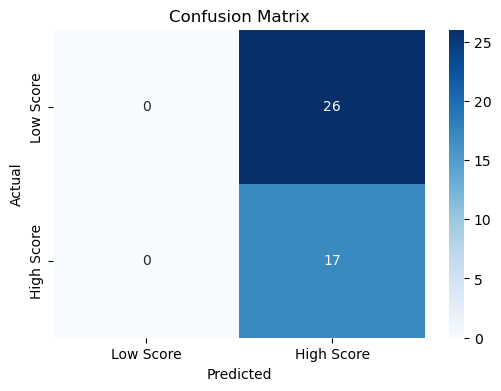

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.40      1.00      0.57        17

    accuracy                           0.40        43
   macro avg       0.20      0.50      0.28        43
weighted avg       0.16      0.40      0.22        43



C:\Users\Justin Roe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Roe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin Roe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Score', 'High Score'], yticklabels=['Low Score', 'High Score'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

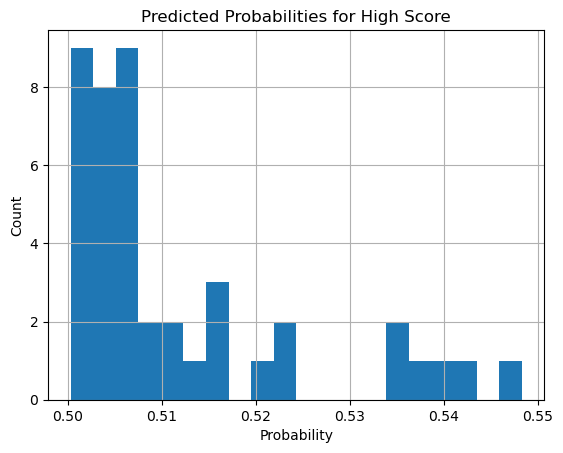

In [13]:
probs = log_reg.predict_proba(X_test)[:, 1]
plt.hist(probs, bins=20)
plt.title("Predicted Probabilities for High Score")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

Conclusion: A movie's runtime (in minutes), rating (PG,PG-13, R, etc), and budget (amount spent to make the movie) do not have a strong relationship with a movie's IMDb rating within the current setup. The model's output is stuck in a "gray area" — not strongly biased, but also not informative. This could in part be due to the small sample size. Additionally, due to the data being pulled from IMDB's Top 250 Movies, there is not much variation in IMDb score as all scores are relatively high. Perhaps a larger dataset and more variety within the IMDb scores would allow a stronger relationship for any of the variables used.